In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# ROC Practice

ROC practice problems from Bill@Deloitte.

Tasks:
1. Plot an ROC Curve
2. Given priors, find operating point.
3. Plot precision as a function of TPR.
4. Confirm that PR depends on tested priors, but ROC does not

## 1. Plot an ROC Curve

An ROC curve is the plot of the FPR vs TPR of a classifier as the discrimation threshold is increased for 0% to 100%.

To plot an ROC curve we first have to obtain results from a classification problem. For this practice set we will generate some dummy data then classify using a logistic regression.

In [8]:
# import the dataset
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, cluster_std=5, centers=2, random_state=123)

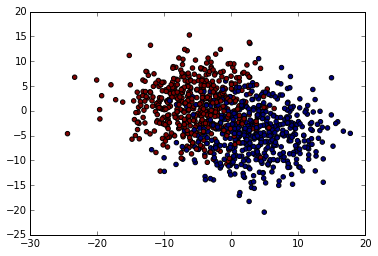

In [9]:
# view the dataset
x1 = [i[0] for i in X]
x2 = [i[1] for i in X]

plt.scatter(x1, x2, c=y)

There is a little bit of overlap in our dummy data, which will give the classifier a little trouble. This is good, or else we will have a perfect classifier and thus a very boring ROC curve.

In [104]:
# split train and test datasets
test_size = 750
train_X = X[:test_size]
train_y = y[:test_size]
test_X = X[test_size:]
test_y = y[test_size:]

In [105]:
# import classifier and build model on first 750 samples
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Now that we have build the model on the training set, let's see what at what probability the model predicts for each of the test set records.

In [106]:
# predict class for last 250 samples
pred_proba_y = classifier.predict_proba(test_X)

Here are the probabilities for the first 5 test set records:

In [107]:
print pred_proba_y[:5]

[[ 0.99827953  0.00172047]
 [ 0.20385812  0.79614188]
 [ 0.00935534  0.99064466]
 [ 0.99068982  0.00931018]
 [ 0.83712337  0.16287663]]


In [113]:
# function to calculate build ROC curve
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

def plot_ROC(pred_proba, y_actual, steps=101):
    # instantiate fpr and tpr arrays
    fpr = []
    tpr = []
    # step through descrimation threshold from 0-1 by step_size
    for thresh in np.linspace(0, 1, num=steps):
        # assign True if probability >= threshold, else False
        y_pred = np.array([proba>=thresh for proba in pred_proba])
        y_actual = np.array(y_actual)
        # calculate tp, fp, fn, and tn counts
        tp = ((y_pred==True) & (y_actual==True)).sum()
        fp = ((y_pred==True) & (y_actual==False)).sum()
        fn = ((y_pred==False) & (y_actual==True)).sum()
        tn = ((y_pred==False) & (y_actual==False)).sum()
        # calculate and append tpr and fpr
        tpr.append(float(tp)/(tp+fn))
        fpr.append(float(fp)/(fp+tn))
    # plot ROC curve
    plt.plot(fpr, tpr)
    plt.show()
    #print fpr
    #print tpr

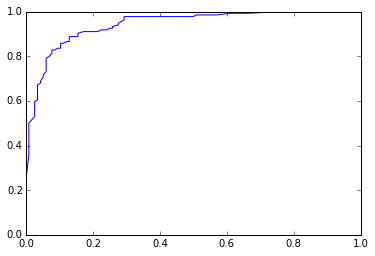

In [114]:
pred_y1 = [p[1] for p in pred_proba_y]
test_y1 = [True if y==1 else False for y in test_y]

plot_ROC(pred_y1, test_y1)
plt.title = "ROC Curve"
plt.xlabel = 'FPR'
plt.ylabel = 'TPR'
plt.show()

## Plot Precision as a function of TPR

In [116]:
# function to calculate build ROC curve
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

def plot_prec_v_tpr(pred_proba, y_actual, steps=101):
    # instantiate fpr and tpr arrays
    prec = []
    tpr = []
    # step through descrimation threshold from 0-1 by step_size
    for thresh in np.linspace(0, 1, num=steps):
        # assign True if probability >= threshold, else False
        y_pred = np.array([proba>=thresh for proba in pred_proba])
        y_actual = np.array(y_actual)
        # calculate tp, fp, fn, and tn counts
        tp = ((y_pred==True) & (y_actual==True)).sum()
        fp = ((y_pred==True) & (y_actual==False)).sum()
        fn = ((y_pred==False) & (y_actual==True)).sum()
        tn = ((y_pred==False) & (y_actual==False)).sum()
        # calculate and append tpr and fpr
        prec.append(float(tp)/(tp+fp))
        fpr.append(float(fp)/(fp+tn))
    # plot ROC curve
    plt.plot(fpr, tpr)
    plt.show()
    #print fpr
    #print tpr

In [117]:
pred_y1 = [p[1] for p in pred_proba_y]
test_y1 = [True if y==1 else False for y in test_y]

plot_prec_v_tpr(pred_y1, test_y1)
plt.title = "ROC Curve"
plt.xlabel = 'FPR'
plt.ylabel = 'TPR'
plt.show()

NameError: global name 'fpr' is not defined